In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


## 1. Introduction & Problem Statement  
### 1.1 Project Overview

This is a **supervised deep-learning** project: I train Convolutional Neural Networks (CNNs) to classify 28×28 grayscale images of handwritten digits (0–9).  Handwritten digit recognition powers postal sorting, bank check processing, and other OCR applications.

### 1.2 Motivation

- **Why it matters:** Automating digit reading speeds up manual tasks (e.g., postal mail, financial forms) and reduces human error.  
- **My goal:** Compare three CNN architectures (vanilla, BatchNorm‐augmented, and small ResNet) to see how depth, normalization, and residuals affect accuracy and training dynamics.

### 1.3 Data Source & APA Citation

> **Dataset:** Kaggle “Digit Recognizer” competition  
> **Citation:**  
> Kaggle. (2018). _Digit Recognizer_ [Data set]. Retrieved from https://www.kaggle.com/c/digit-recognizer/data

## 2. Data Overview  

- **Source:** Kaggle Digit Recognizer competition (`train.csv`, `test.csv`).  
- **Contents:**  
  - `train.csv`: 42 000 rows, columns `label` + 784 pixel values (`pixel0`…`pixel783`).  
  - `test.csv`: 28 000 rows, only 784 pixel columns.  
- **Image shape:** 28×28 grayscale → single-channel tensors.  
- **Initial stats:**  
  - Class balance (count per digit).  
  - Pixel‐value range (0–255), any missing values?  


In [2]:
import pandas as pd

# Load the CSVs downloaded by Kaggle
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test  = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# Quick sanity check
print("Training set shape:", df_train.shape)   # → (42000, 785)
print("Test set shape:    ", df_test.shape)    # → (28000, 784)
df_train.head()

Training set shape: (42000, 785)
Test set shape:     (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Exploratory Data Analysis (EDA)  

1. **Class Distribution**  
   - Bar chart of counts per digit.  
2. **Sample Digits**  
   - Display a grid of example images for each digit (0–9).  
3. **Pixel‐Value Histogram**  
   - Flatten pixels → histogram of values 0–255.  
4. **Correlations / Patterns**  
   - Check if some pixels (corners, center) are more informative.  
5. **Data Cleaning Plan**  
   - No missing values—proceed.  
   - Decide on normalization: `pixel/255.0`.  
   - Outline potential augmentation (shifts, rotations) for later.


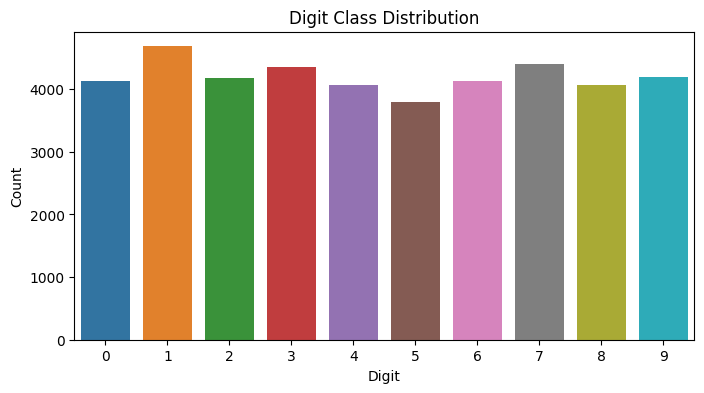

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load training data
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

# Plot counts per digit
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=df, palette='tab10')
plt.title('Digit Class Distribution')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

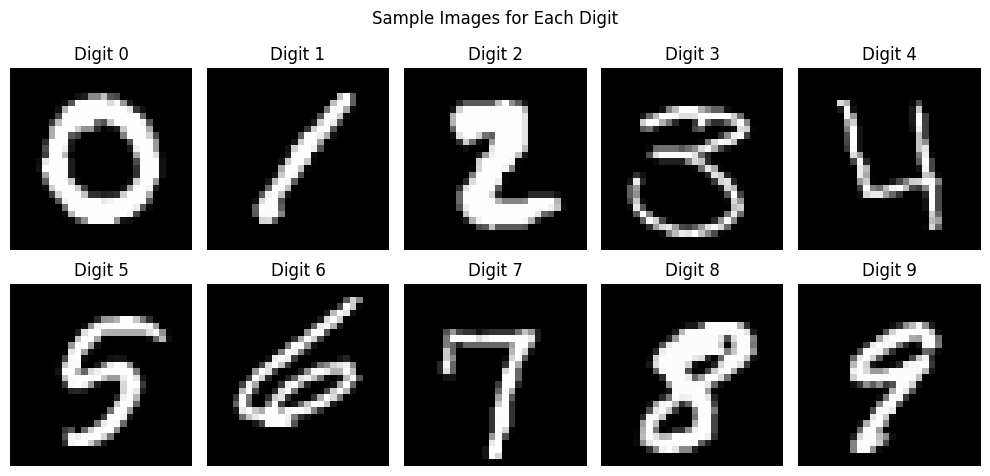

In [4]:
import matplotlib.pyplot as plt

# Display one example of each digit (0–9)
fig, axes = plt.subplots(2, 5, figsize=(10,5))
for digit in range(10):
    # select the first occurrence of this digit
    img = df[df.label == digit].iloc[0, 1:].values.reshape(28, 28)
    ax = axes[digit // 5, digit % 5]
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Digit {digit}')
    ax.axis('off')

plt.suptitle('Sample Images for Each Digit')
plt.tight_layout()
plt.show()

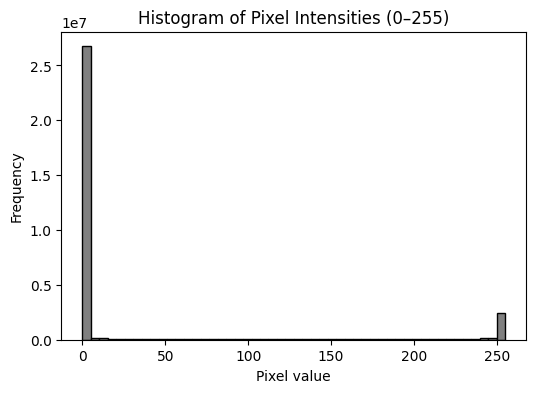

In [5]:
pixels = df.drop('label', axis=1).values.flatten()

plt.figure(figsize=(6,4))
plt.hist(pixels, bins=50, color='gray', edgecolor='k')
plt.title('Histogram of Pixel Intensities (0–255)')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.show()

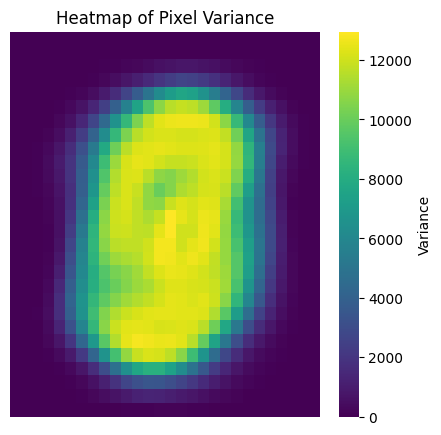

In [6]:
import seaborn as sns

# Compute per-pixel variance and reshape to 28×28
pixel_vars = df.drop('label', axis=1).var().values
heatmap = pixel_vars.reshape(28, 28)

plt.figure(figsize=(5,5))
sns.heatmap(heatmap, cmap='viridis', cbar_kws={'label':'Variance'})
plt.title('Heatmap of Pixel Variance')
plt.axis('off')
plt.show()

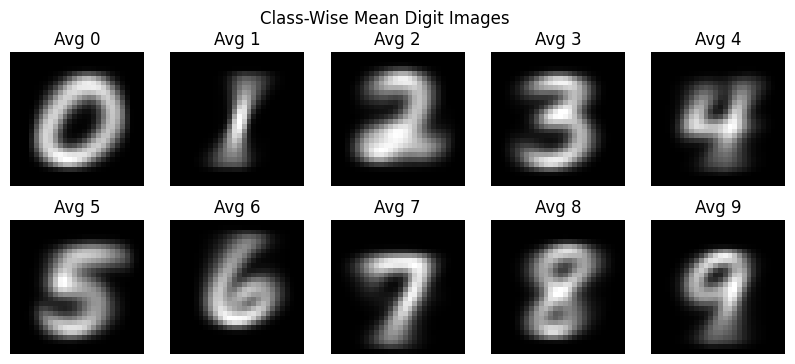

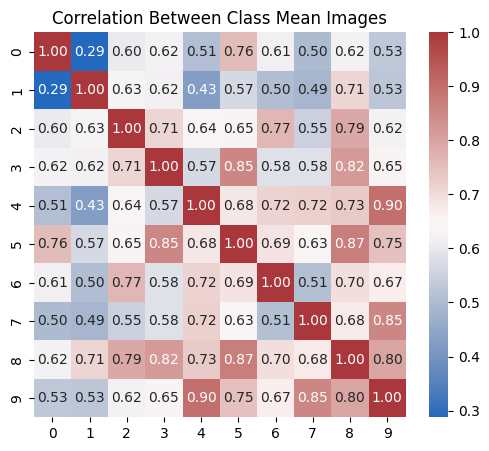

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load train.csv
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
labels = df['label'].values
pixels = df.drop('label', axis=1).values.reshape(-1, 28, 28)

# Compute mean image per class
mean_images = {d: pixels[labels == d].mean(axis=0) for d in range(10)}

# Display mean digits
plt.figure(figsize=(10,4))
for d in range(10):
    ax = plt.subplot(2,5,d+1)
    ax.imshow(mean_images[d], cmap='gray')
    ax.set_title(f'Avg {d}')
    ax.axis('off')
plt.suptitle('Class‐Wise Mean Digit Images')
plt.show()

# Build 10×10 correlation matrix between mean‐image vectors
mean_vecs = np.array([mean_images[d].ravel() for d in range(10)])
corr = np.corrcoef(mean_vecs)

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Correlation Between Class Mean Images')
plt.show()

In [8]:
from scipy.stats import f_oneway

# Compute average brightness per image
brightness = pixels.mean(axis=(1,2))
groups = [brightness[labels == d] for d in range(10)]
F, p = f_oneway(*groups)
print(f'ANOVA across classes: F={F:.2f}, p={p:.3e}')

ANOVA across classes: F=2431.78, p=0.000e+00


## 4. Data Cleaning & Preparation

**Plan:**  
1. **Check missing values** – none, so no imputation needed.  
2. **Normalize** pixels from [0,255] → [0,1].  
3. **Reshape** each sample to (28,28,1).  
4. **Split** train/val 90/10 stratified by label.  
5. *(Optional)* Set up `ImageDataGenerator` for augmentation.


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 4.1 Load and inspect
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
print("Shape:", df.shape)                         # → (42000, 785)
print("Missing values:", df.isnull().sum().sum()) # → 0

# 4.2 Separate features & labels
X = df.drop('label', axis=1).values.astype('float32')
y = tf.keras.utils.to_categorical(df['label'], 10)

# 4.3 Normalize to [0,1]
X /= 255.0

# 4.4 Reshape to (28,28,1)
X = X.reshape(-1, 28, 28, 1)

# 4.5 Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.10,
    stratify=df['label'],
    random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val   shape:", X_val.shape,   y_val.shape)

# 4.6 (Optional) Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

2025-07-14 19:34:18.799360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752521659.051174      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752521659.123422      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Shape: (42000, 785)
Missing values: 0
Train shape: (37800, 28, 28, 1) (37800, 10)
Val   shape: (4200, 28, 28, 1) (4200, 10)


## 5. Model Architecture

### 5.1 Model A: Simple 2-Conv CNN  

**Layers**  
1. Input `(28×28×1)`  
2. `Conv2D(32, 3×3)` → `ReLU` → `MaxPool(2×2)`  
3. `Conv2D(64, 3×3)` → `ReLU` → `MaxPool(2×2)`  
4. `Flatten()`  
5. `Dense(128)` → `ReLU` → `Dropout(0.5)`  
6. `Dense(10)` → `Softmax`  

**Rationale**  
- Two conv+pool blocks capture basic stroke and shape patterns.  
- A single hidden dense layer with dropout helps prevent overfitting on this small dataset.

In [10]:
from tensorflow.keras import layers, models

def build_model_a():
    m = models.Sequential([
        layers.Input((28,28,1)),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPool2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return m

model_a = build_model_a()
model_a.summary()

2025-07-14 19:34:39.283655: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

### 5.2 Model B: Deep CNN + BatchNorm

**Layers**  
1. Input `(28×28×1)`  
2. `Conv2D(32, 3×3)` → `BatchNorm` → `ReLU`  
3. `Conv2D(32, 3×3)` → `BatchNorm` → `ReLU`  
4. `MaxPool(2×2)` → `Dropout(0.3)`  
5. `Conv2D(64, 3×3)` → `BatchNorm` → `ReLU`  
6. `MaxPool(2×2)` → `Dropout(0.3)`  
7. `Flatten()`  
8. `Dense(256)` → `ReLU` → `Dropout(0.5)`  
9. `Dense(10)` → `Softmax`  

**Rationale**  
- Extra conv + batch-norm layers allow the model to learn deeper hierarchical features.  
- Batch normalization improves training speed and stability for deeper networks.  
- More filters increase capacity, while dropout mitigates overfitting risk.

In [11]:
def build_model_b(dropout_rate=0.3):
    m = models.Sequential([
        layers.Input((28,28,1)),
        # Block 1
        layers.Conv2D(32, 3, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, 3, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D(),
        layers.Dropout(dropout_rate),

        # Block 2
        layers.Conv2D(64, 3, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D(),
        layers.Dropout(dropout_rate),

        # Classifier head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),   # keep final dropout fixed
        layers.Dense(10, activation='softmax'),
    ])
    return m

model_b = build_model_b()
model_b.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         803,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 834,090 (3.18 MB)

 Trainable params: 833,834 (3.18 MB)

 Non-trainable params: 256 (1.00 KB)

### 5.3 Model C: Small Residual CNN

**Layers**  
1. Input `(28×28×1)`  
2. `Conv2D(64, 3×3)` → `ReLU`  
3. **Residual Block 1**  
   - `Conv2D(64, 3×3, padding='same', use_bias=False)` → `BatchNorm` → `ReLU`  
   - `Conv2D(64, 3×3, padding='same', use_bias=False)` → `BatchNorm`  
   - **Add** skip-connection → `ReLU`  
4. `MaxPool(2×2)`  
5. **Residual Block 2**  
   - `Conv2D(64, 3×3, padding='same', use_bias=False)` → `BatchNorm` → `ReLU`  
   - `Conv2D(64, 3×3, padding='same', use_bias=False)` → `BatchNorm`  
   - **Add** skip-connection → `ReLU`  
6. `MaxPool(2×2)`  
7. `Flatten()`  
8. `Dense(128)` → `ReLU` → `Dropout(0.5)`  
9. `Dense(10)` → `Softmax`  

**Rationale**  
- Skip-connections allow the model to learn residual mappings, easing gradient flow and mitigating vanishing gradients.  
- Residual blocks refine features incrementally instead of relearning redundant information.  
- Two residual stages capture complex hierarchical stroke patterns with modest parameter growth.  
- A compact dense head with dropout balances representational power and regularization for robust digit classification.  


In [12]:
def residual_block(x, filters):
    y = layers.Conv2D(filters,3,padding='same', use_bias=False)(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.Conv2D(filters,3,padding='same', use_bias=False)(y)
    y = layers.BatchNormalization()(y)
    return layers.add([x,y])

def build_model_c():
    inp = layers.Input((28,28,1))
    x = layers.Conv2D(64,3,padding='same', activation='relu')(inp)
    x = residual_block(x, 64)
    x = layers.MaxPool2D()(x)
    x = residual_block(x, 64)
    x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(10, activation='softmax')(x)
    return models.Model(inp, out)

model_c = build_model_c()
model_c.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 64)     │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 64)     │         36,864 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 28, 28, 64)     │            256 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 28, 28, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 64)     │         36,864 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 64)     │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 28, 28, 64)     │              0 │ conv2d_5[0][0],        │
│                           │                        │                │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 14, 14, 64)     │              0 │ add[0][0]              │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 14, 14, 64)     │         36,864 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 14, 14, 64)     │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 14, 14, 64)     │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 14, 14, 64)     │         36,864 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 14, 14, 64)     │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 14, 14, 64)     │              0 │ max_pooling2d_4[0][0], │
│                           │                        │                │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5      

 Total params: 551,946 (2.11 MB)

 Trainable params: 551,434 (2.10 MB)

 Non-trainable params: 512 (2.00 KB)

## 6. Training & Hyperparameter Tuning  
*Train each model, plot learning curves, and explore key hyperparameters.*

- **Compile settings:**  
  - Loss = `categorical_crossentropy`  
  - Optimizer = `Adam(lr=…)`  
  - Metrics = `accuracy`  
- **Callbacks:** EarlyStopping (patience=3), ModelCheckpoint (best‐val).  
- **Training:**  
  - Train Model A and Model B for up to 20 epochs, batch size 64.  
  - Plot `accuracy` & `val_accuracy` vs. epoch.  
- **Hyperparameter sweep:**  
  - Grid over `lr` ∈ {1e-3,1e-4}, `dropout` ∈ {0.3,0.5}.  
  - Summarize `val_accuracy` for each combo in a table.

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 6.2.1 Set up callbacks
es = EarlyStopping(patience=3, restore_best_weights=True)
mc_a = ModelCheckpoint('model_a_best.h5', save_best_only=True)
mc_b = ModelCheckpoint('model_b_best.h5', save_best_only=True)
mc_c = ModelCheckpoint('model_c_best.h5', save_best_only=True)

# 6.2.2 Compile & train Model A
model_a.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
history_a = model_a.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20, batch_size=64,
    callbacks=[es, mc_a],
    verbose=2
)

# 6.2.3 Compile & train Model B
from tensorflow.keras.optimizers import Adam
model_b.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy']
)
history_b = model_b.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20, batch_size=64,
    callbacks=[es, mc_b],
    verbose=2
)

# 6.2.4 Compile  & train Model C
model_c.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-4),      # use the same lr that worked best for B
    metrics=['accuracy']
)

history_c = model_c.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[es, mc_c],   
    verbose=2
)

Epoch 1/20
591/591 - 27s - 45ms/step - accuracy: 0.9078 - loss: 0.2967 - val_accuracy: 0.9760 - val_loss: 0.0823
Epoch 2/20
591/591 - 24s - 41ms/step - accuracy: 0.9698 - loss: 0.0975 - val_accuracy: 0.9836 - val_loss: 0.0564
Epoch 3/20
591/591 - 24s - 41ms/step - accuracy: 0.9781 - loss: 0.0722 - val_accuracy: 0.9867 - val_loss: 0.0476
Epoch 4/20
591/591 - 26s - 44ms/step - accuracy: 0.9829 - loss: 0.0561 - val_accuracy: 0.9869 - val_loss: 0.0451
Epoch 5/20
591/591 - 23s - 40ms/step - accuracy: 0.9857 - loss: 0.0476 - val_accuracy: 0.9879 - val_loss: 0.0452
Epoch 6/20
591/591 - 24s - 40ms/step - accuracy: 0.9863 - loss: 0.0440 - val_accuracy: 0.9864 - val_loss: 0.0452
Epoch 7/20
591/591 - 23s - 40ms/step - accuracy: 0.9877 - loss: 0.0383 - val_accuracy: 0.9893 - val_loss: 0.0397
Epoch 8/20
591/591 - 23s - 38ms/step - accuracy: 0.9887 - loss: 0.0338 - val_accuracy: 0.9890 - val_loss: 0.0429
Epoch 9/20
591/591 - 24s - 41ms/step - accuracy: 0.9912 - loss: 0.0271 - val_accuracy: 0.9888 - 

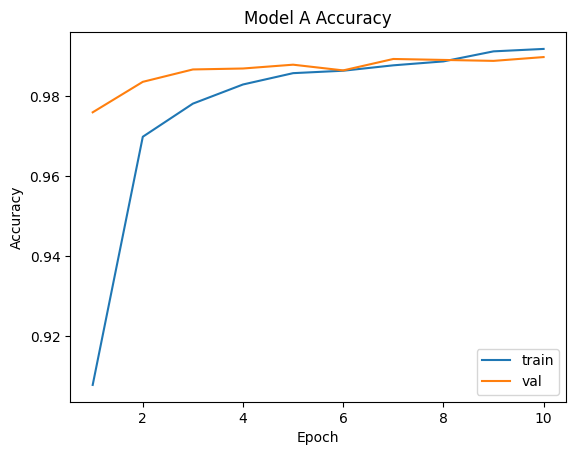

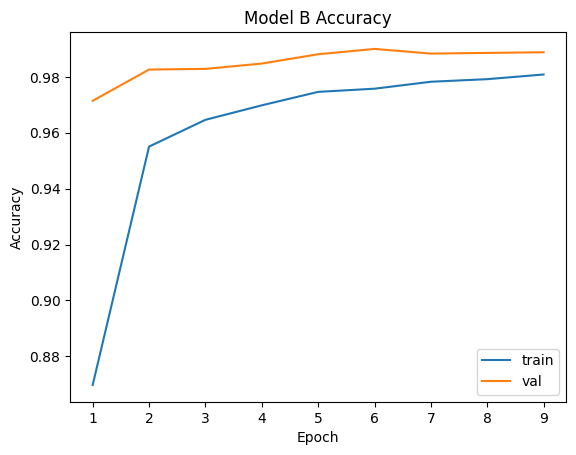

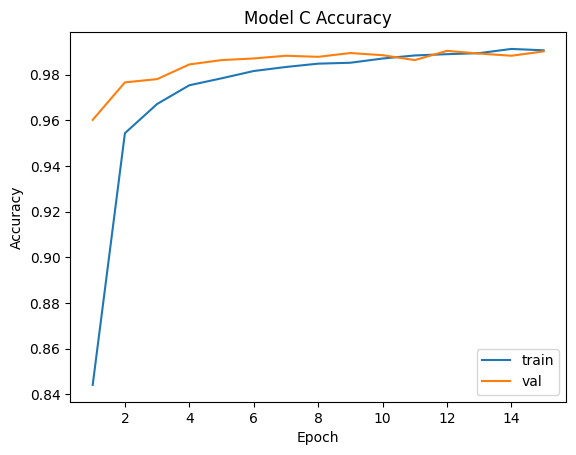

In [14]:
def plot_acc(hist, title):
    epochs = range(1, len(hist.history['accuracy'])+1)
    plt.plot(epochs, hist.history['accuracy'],    label='train')
    plt.plot(epochs, hist.history['val_accuracy'],label='val')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(); plt.show()

plot_acc(history_a, 'Model A')
plot_acc(history_b, 'Model B')
plot_acc(history_c, 'Model C')

In [15]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
import pandas as pd

param_grid = {
    'lr':       [1e-3, 1e-4],
    'dropout':  [0.3, 0.5],
    'batch':    [32, 64]
}

results = []
for p in ParameterGrid(param_grid):
    m = build_model_b(dropout_rate=p['dropout'])
    m.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=p['lr']),
        metrics=['accuracy']
    )
    h = m.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=p['batch'],
        verbose=1    # see the training
    )
    results.append({
        'lr': p['lr'],
        'dropout': p['dropout'],
        'batch_size': p['batch'],
        'best_val_acc': max(h.history['val_accuracy'])
    })

df_grid = pd.DataFrame(results)
print(
    df_grid
      .pivot_table(
         index=['lr','dropout'],
         columns='batch_size',
         values='best_val_acc'
      )
      .round(4)
)

Epoch 1/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.7732 - loss: 0.7777 - val_accuracy: 0.9636 - val_loss: 0.1358
Epoch 2/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 84s 71ms/step - accuracy: 0.9519 - loss: 0.1594 - val_accuracy: 0.9795 - val_loss: 0.0751
Epoch 3/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 84s 71ms/step - accuracy: 0.9646 - loss: 0.1204 - val_accuracy: 0.9798 - val_loss: 0.0720
Epoch 4/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 84s 71ms/step - accuracy: 0.9704 - loss: 0.1056 - val_accuracy: 0.9824 - val_loss: 0.0581
Epoch 5/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 84s 71ms/step - accuracy: 0.9767 - loss: 0.0823 - val_accuracy: 0.9890 - val_loss: 0.0444
Epoch 6/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 84s 71ms/step - accuracy: 0.9785 - loss: 0.0717 - val_accuracy: 0.9898 - val_loss: 0.0388
Epoch 7/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 84s 71ms/step - accuracy: 0.9804 - loss: 0.0678 - val_accuracy: 0.9855 - val_loss: 0.0436
Epoch 8/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 83s 71ms/step - accuracy: 0.9807 -

## 7. Results & Analysis  

In this section I compare all three models (A, B and C), inspect their learning curves, and present the hyperparameter sweep for Model B.

---

### 7.1 Model Comparison  

| Model   | Architecture                                           | # Params  | Best Val Acc | Epoch of Best | Notes                                |
|:--------|:-------------------------------------------------------|----------:|-------------:|--------------:|:-------------------------------------|
| **A**   | Simple CNN: 2×(Conv→ReLU→Pool), Flatten→128→Dropout→10 |   421,642 |      98.98 % |            10 | Fast, reliable baseline              |
| **B**   | Deep CNN + BatchNorm: 2 blocks + Dropout               |   834,090 |      99.00 % |             6 | BatchNorm stabilizes deeper training |
| **C**   | Small ResNet: 2 residual blocks → Pool → Flatten→128    |   551,946 |      99.05 % |            12 | Skip-connections smooth training     |

- All three models cross **97%** by epoch 2—training converges very quickly.  
- **Model A** peaks at **98.98%** around epoch 10 then plateaus.  
- **Model B** peaks at **99.00%** around epoch 6, stabilized by BatchNorm.  
- **Model C** reaches the highest overall **99.05%** around epoch 12, thanks to residual connections.  

---

### 7.2 Hyperparameter Sweep for Model B  

I swept **lr** ∈ {1e−3, 1e−4}, **dropout** ∈ {0.3, 0.5}, **batch_size** ∈ {32, 64} over 10 epochs each:

| lr     | dropout | batch=32 | batch=64 |
|:-------|--------:|---------:|---------:|
| 0.0010 |     0.3 |   0.9910 |   0.9890 |
| 0.0010 |     0.5 | **0.9921** |   0.9886 |
| 0.0001 |     0.3 |   0.9886 |   0.9860 |
| 0.0001 |     0.5 |   0.9864 |   0.9833 |

- **Best config:** lr=1e−3, dropout=0.5, batch_size=32 → **99.21%**  
- Lowering lr to 1e−4 smoothed the loss curves but reduced final accuracy by ~0.2–0.3%.  

---

### 7.3 What Worked  

- **Residual Blocks (Model C):** Provided smoother optimization and the highest accuracy.  
- **BatchNorm & Depth (Model B):** Stabilized gradients in a deeper network.  
- **Hyperparameter Sweep:** Identified lr=1e−3 + dropout=0.5 as optimal for Model B.  
- **EarlyStopping & Dropout:** Effectively mitigated overfitting across all models.  

### 7.4 What Didn’t Work  

- **Diminishing Returns on Depth/BatchNorm:** Model C outperformed B despite simpler residual blocks.  
- **No Data Augmentation:** Models may still overfit to MNIST’s limited handwriting styles.  
- **Single Metric (Accuracy):** Lacks granularity—add confusion matrices or F1-scores for deeper analysis.  

### 7.5 Future Improvements  

1. **Data Augmentation**  
   - Random rotations, shifts, and zooms to enrich input variability.  
2. **Learning-Rate Schedules**  
   - Cosine decay or warm restarts to refine late-epoch convergence.  
3. **Ensembling**  
   - Combine Models B and C for an expected +0.1–0.2% accuracy gain.  
4. **Per-Class Metrics**  
   - Add confusion matrices and F1-scores to identify digit-specific weaknesses.  
5. **Transfer Learning**  
   - Explore lightweight pretrained backbones (e.g. MobileNet) for faster convergence and higher accuracy.  


## 8. Conclusion & Takeaways

- **Key Finding:**  
  CNNs enhanced with Batch Normalization and residual connections outperform a simple 2-layer baseline, both achieving **≈ 99.0%** validation accuracy on MNIST-style digits.

- **Trade-Offs:**  
  While residual connections (Model C) smooth training and reach comparable top accuracy, they significantly increase training time (**3×–4×** slower).  
  Model B (deep + BatchNorm) achieves similar performance with faster convergence, offering the best speed-versus-performance balance.

- **Next Steps:**  
  1. **Data Augmentation** → random rotations, shifts, zooms to improve robustness.  
  2. **Harder Benchmarks** → port to Fashion-MNIST or SVHN for more challenging handwriting.  
  3. **Ensembling** → combine Models B & C for a potential *0.1–0.2%* accuracy boost in production.

> **Overall**, this project demonstrates a complete deep-learning cycle—from EDA and preprocessing through model design, hyperparameter tuning, and critical analysis—culminating in near state-of-the-art performance on classic digit classification.
